In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine

if os.getcwd().endswith('notebook'):
    os.chdir('..')

In [2]:
sns.set(palette='colorblind', font_scale=1.3)

In [3]:
db_path = os.path.join(os.getcwd(), 'data/condensed_traits/db/seq.db')
engine = create_engine(f'sqlite+pysqlite:///{db_path}')

In [4]:
growth_temperatures = pd.read_sql(
    'select growth_tmp from species_traits',
    engine,
)['growth_tmp'].values

In [5]:
unique_rounded_temperatures = np.unique([int(round(t)) for t in growth_temperatures])
unique_rounded_temperatures

array([  4,   5,   8,   9,  10,  11,  12,  14,  15,  16,  17,  18,  20,
        21,  22,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32,  33,
        34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,
        47,  48,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,
        61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,
        74,  75,  76,  77,  78,  79,  80,  81,  83,  84,  85,  86,  87,
        88,  89,  90,  94,  95,  97,  98,  99, 100, 103, 104])

In [6]:
min_ = int(np.floor(np.min(growth_temperatures)))
max_ = int(np.ceil(np.max(growth_temperatures)))
step = 3
bins = list(range(min_, max_, step)) + [max_]

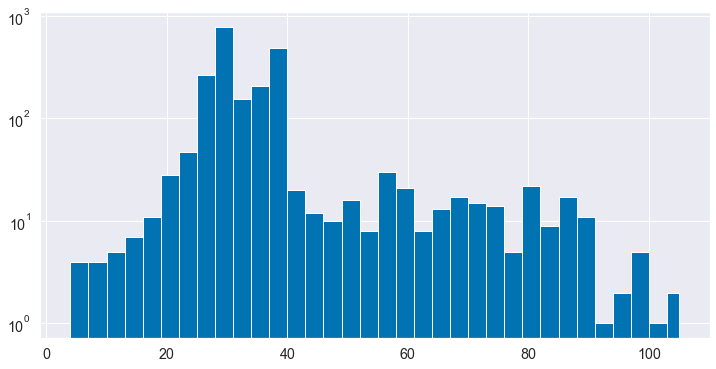

In [7]:
_, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.hist(growth_temperatures, bins=bins, log=True);

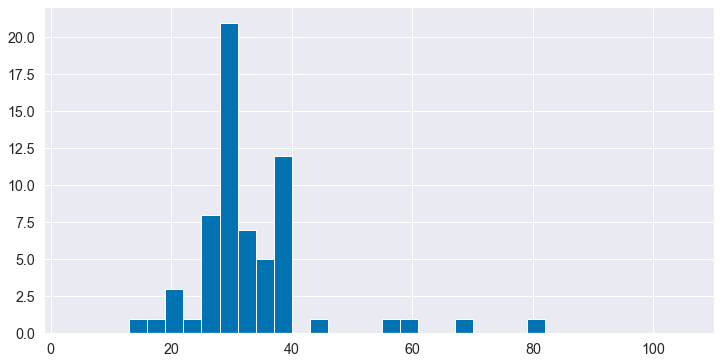

In [8]:
_, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.hist(np.random.choice(growth_temperatures, size=64, replace=False), bins=bins);

In [9]:
def compute_inverse_probability_weights(growth_temperatures, step=3):
    min_ = int(np.floor(np.min(growth_temperatures)))
    max_ = int(np.ceil(np.max(growth_temperatures)))
    bins = list(range(min_, max_, step)) + [max_]
    total = len(growth_temperatures)
    values, _ = np.histogram(growth_temperatures, bins)
    weights_dict = {
        b: total / values[i]
        for i, b in enumerate(bins[:-1])
    }
    return weights_dict, bins

In [10]:
weights_dict, bins = compute_inverse_probability_weights(growth_temperatures)

In [11]:
weights_dict

{4: 566.25,
 7: 566.25,
 10: 453.0,
 13: 323.57142857142856,
 16: 205.9090909090909,
 19: 80.89285714285714,
 22: 48.191489361702125,
 25: 8.451492537313433,
 28: 2.9038461538461537,
 31: 14.51923076923077,
 34: 10.889423076923077,
 37: 4.641393442622951,
 40: 113.25,
 43: 188.75,
 46: 226.5,
 49: 141.5625,
 52: 283.125,
 55: 75.5,
 58: 107.85714285714286,
 61: 283.125,
 64: 174.23076923076923,
 67: 133.23529411764707,
 70: 151.0,
 73: 161.78571428571428,
 76: 453.0,
 79: 102.95454545454545,
 82: 251.66666666666666,
 85: 133.23529411764707,
 88: 205.9090909090909,
 91: 2265.0,
 94: 1132.5,
 97: 453.0,
 100: 2265.0,
 103: 1132.5}

In [12]:
def assign_weight_to_batch_values(growth_temperatures, weights_dict, bins, dtype='float32'):
    index = np.digitize(growth_temperatures, bins)
    weights_u = np.array(
        [weights_dict[bins[ix-1]] for ix in index],
        dtype=dtype,
    )
    return weights_u / np.sum(weights_u)

In [13]:
weights = assign_weight_to_batch_values(
    np.random.choice(growth_temperatures, size=64, replace=False),
    weights_dict, 
    bins,
)
len(weights)

64

In [14]:
weights

array([0.00299684, 0.00937474, 0.00545694, 0.06964095, 0.00187495,
       0.08602706, 0.00187495, 0.00187495, 0.00187495, 0.00299684,
       0.00187495, 0.00187495, 0.00299684, 0.00187495, 0.00299684,
       0.00937474, 0.00187495, 0.00187495, 0.00299684, 0.00187495,
       0.00703106, 0.00299684, 0.00703106, 0.00937474, 0.12187167,
       0.00299684, 0.00187495, 0.00187495, 0.00299684, 0.00187495,
       0.00545694, 0.00187495, 0.00187495, 0.00187495, 0.00187495,
       0.00187495, 0.00703106, 0.00299684, 0.00299684, 0.00187495,
       0.146246  , 0.00299684, 0.00937474, 0.00187495, 0.00299684,
       0.00187495, 0.00937474, 0.00703106, 0.00187495, 0.00545694,
       0.00703106, 0.00299684, 0.12187167, 0.00299684, 0.00299684,
       0.09140375, 0.00545694, 0.00937474, 0.00187495, 0.00703106,
       0.05223072, 0.09749734, 0.00299684, 0.00187495], dtype=float32)

In [15]:
weights = assign_weight_to_batch_values(
    growth_temperatures,
    weights_dict, 
    bins,
)
len(weights)

2265

In [16]:
def mae(y_true, y_pred, weights=None):
    return np.average(np.abs(y_true - y_pred), weights=weights)

In [17]:
mean_ogt = np.mean(growth_temperatures)
mean_ogt

34.99763222958057

In [18]:
mae(growth_temperatures, mean_ogt)

8.0155055129161

In [19]:
mae(growth_temperatures, mean_ogt, weights)

29.354706465396497

In [20]:
%%time
from rna_learn.load_sequences import load_train_sequence_rowids
_, lengths = load_train_sequence_rowids(engine)

CPU times: user 21 s, sys: 13.8 s, total: 34.8 s
Wall time: 1min 23s


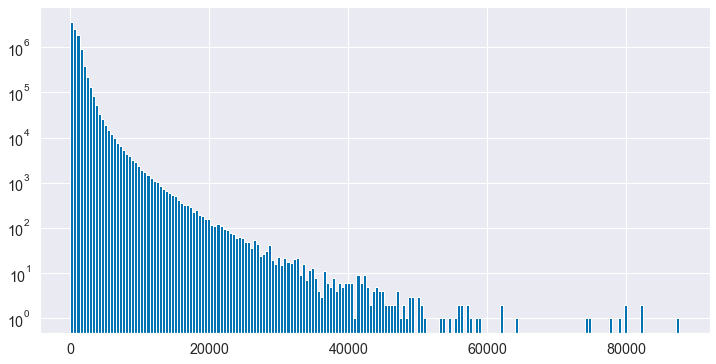

In [21]:
_, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.hist(lengths, bins=200, log=True);

In [22]:
under_1000 = len([_ for l in lengths if l <= 1000])
100 * under_1000 / len(lengths)

68.07537263689609

In [23]:
b_1000_5000 = len([_ for l in lengths if l > 1000 and l <= 5000])
100 * b_1000_5000 / len(lengths)

30.931808092311886

In [75]:
bins = [1, 500, 1000, 2000, 3000, 4000, 5000, 1e4, 2e4, 3e4, 4e4, 5e4, 6e4, 7e4, 8e4, 9e4]
hist, outer_bins = np.histogram(lengths, bins=bins)
cdf = np.cumsum(hist) / len(lengths)
v = [0] + cdf.tolist()
cdf = [100 * (b - a) for a, b in zip(v, v[1:])]

In [76]:
len(cdf), len(bins), len(outer_bins)

(15, 16, 16)

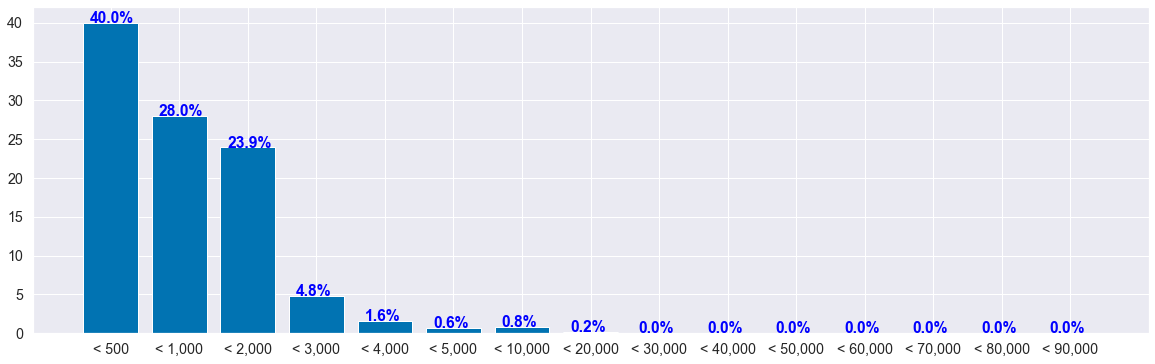

In [78]:
_, ax = plt.subplots(1, 1, figsize=(20, 6))
ax.bar([f'< {int(b):,}' for b in bins[1:]], cdf);

for i, v in enumerate(cdf):
    ax.text(i - 0.3, v, f'{round(v, 1)}%', color='blue', fontweight='bold')

In [85]:
bins = [
    1, 500, 1000, 2000, 3000, 4000, 
    5000, 1e4, 2e4, np.inf,
]
hist, _ = np.histogram(lengths, bins=bins)
cdf = np.cumsum(hist)
v = [0] + cdf.tolist()
cdf = [(b - a) for a, b in zip(v, v[1:])]
w = cdf / np.sum(cdf)
print(w)

[4.00231967e-01 2.80472622e-01 2.39456817e-01 4.78530766e-02
 1.57510344e-02 6.30308118e-03 8.17410002e-03 1.57559481e-03
 1.81706835e-04]
